In [ ]:
import sys
!"{sys.executable}" -m pip install tqdm



In [ ]:
import sys
!"{sys.executable}" -m pip install tensorflow==2.12 opencv-python matplotlib seaborn mahotas scikit-learn==1.1.3 tqdm imblearn


Processing Potato___healthy: 100%|███████████████████████████████████████████████████| 152/152 [00:14<00:00, 10.66it/s]


Classification Report:

                       precision    recall  f1-score   support

Potato___Early_blight       0.96      1.00      0.98       217
 Potato___Late_blight       0.99      0.90      0.94       197
     Potato___healthy       0.94      1.00      0.97       186

             accuracy                           0.96       600
            macro avg       0.97      0.96      0.96       600
         weighted avg       0.97      0.96      0.96       600



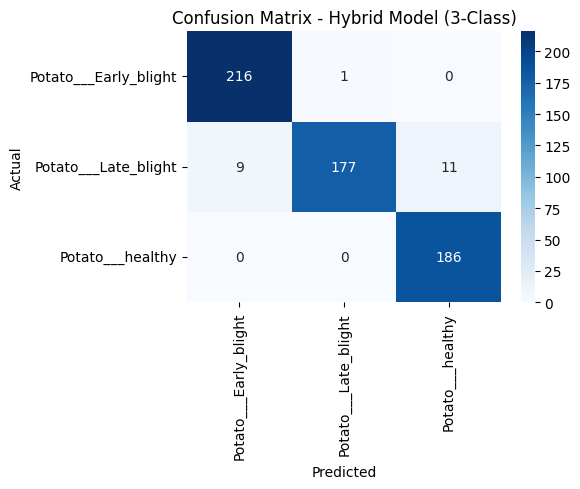

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import mahotas

# 📁 Dataset Path (adjust if needed)
dataset_path = "D:/major_proj/3class potato data"
img_size = (224, 224)

# 🔧 Load EfficientNetB0 for CNN features
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
cnn_model = Model(inputs=base_model.input, outputs=base_model.output)

# 🔍 Extract Features
cnn_features, glcm_features, labels = [], [], []
class_names = sorted(os.listdir(dataset_path))
label_map = {cls: i for i, cls in enumerate(class_names)}

for cls in class_names:
    cls_path = os.path.join(dataset_path, cls)
    for fname in tqdm(os.listdir(cls_path), desc=f"Processing {cls}"):
        try:
            path = os.path.join(cls_path, fname)

            # CNN
            img = image.load_img(path, target_size=img_size)
            arr = image.img_to_array(img)
            arr = np.expand_dims(arr, axis=0)
            arr = preprocess_input(arr)
            cnn_feat = cnn_model.predict(arr, verbose=0).flatten()
            cnn_features.append(cnn_feat)

            # GLCM using Mahotas
            img_cv = cv2.imread(path)
            gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
            glcm_feat = mahotas.features.haralick(gray).mean(axis=0)
            glcm_features.append(glcm_feat)

            labels.append(label_map[cls])
        except Exception as e:
            print("Skipped:", fname, e)

# ✅ Stack Features
X_cnn = np.array(cnn_features)
X_glcm = np.array(glcm_features)
X = np.concatenate((X_cnn, X_glcm), axis=1)
y = np.array(labels)

# 🧠 PCA (optional but helpful)
pca = PCA(n_components=300)
X_pca = pca.fit_transform(X)

# ⚖️ Balance with SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_pca, y)

# 📊 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# 🤖 Train MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# 📈 Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Hybrid Model (3-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [8]:
data_dir = 'D:/major_proj/3class potato data/'

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# Step 1: Load EfficientNetB0 without top
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Step 2: Freeze layers initially
base_model.trainable = False

# Step 3: Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # for 3 classes

# Step 4: Final model
model = Model(inputs=base_model.input, outputs=output)


In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3),  # higher LR for initial training
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
54/54 [==============================] - 57s 966ms/step - loss: 0.5435 - accuracy: 0.8229 - val_loss: 0.2821 - val_accuracy: 0.9116
Epoch 2/5
54/54 [==============================] - 49s 919ms/step - loss: 0.2085 - accuracy: 0.9443 - val_loss: 0.1776 - val_accuracy: 0.9651
Epoch 3/5
54/54 [==============================] - 50s 921ms/step - loss: 0.1372 - accuracy: 0.9733 - val_loss: 0.1301 - val_accuracy: 0.9698
Epoch 4/5
54/54 [==============================] - 50s 926ms/step - loss: 0.1063 - accuracy: 0.9791 - val_loss: 0.1077 - val_accuracy: 0.9721
Epoch 5/5
54/54 [==============================] - 50s 923ms/step - loss: 0.0873 - accuracy: 0.9826 - val_loss: 0.0969 - val_accuracy: 0.9721


In [15]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")


14/14 [==============================] - 11s 752ms/step - loss: 0.0969 - accuracy: 0.9721
Test Accuracy: 0.9721


In [18]:
# Fetch class names BEFORE applying .prefetch()
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "D:/major_proj/3class potato data",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = raw_train_ds.class_names
print(class_names)  # Just to verify


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


14/14 [==============================] - 11s 741ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.99      0.99       182
 Potato___Late_blight       0.95      1.00      0.97       208
     Potato___healthy       0.97      0.75      0.85        40

             accuracy                           0.97       430
            macro avg       0.97      0.91      0.94       430
         weighted avg       0.97      0.97      0.97       430



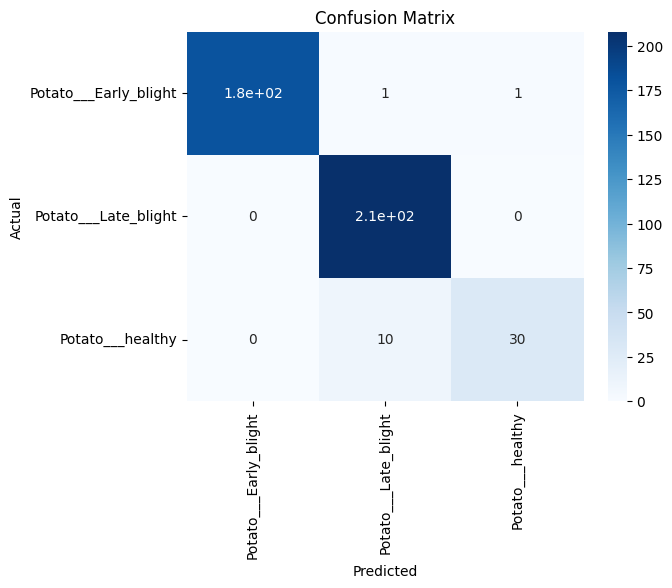

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
!pip install scikit-image


In [24]:
import sys
print(sys.executable)


C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\python.exe


In [28]:
import sys
!"{sys.executable}" -m pip install scikit-image --quiet



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [30]:
import sys
!"{sys.executable}" -m pip uninstall scikit-image -y
!"{sys.executable}" -m pip install scikit-image==0.19.3 --no-cache-dir


Found existing installation: scikit-image 0.24.0
Uninstalling scikit-image-0.24.0:
  Successfully uninstalled scikit-image-0.24.0


You can safely remove it manually.


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.1 MB 4.6 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/12.1 MB 2.9 MB/s eta 0:00:04
   ------ --------------------------------- 2.1/12.1 MB 3.7 MB/s eta 0:00:03
   ---------- ----------------------------- 3.1/12.1 MB 4.1 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/12.1 MB 3.6 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.1 MB 3.8 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.1 MB 3.8 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.1 MB 3.8 MB/s eta 0:00:03
   ---------------- ----------------------- 5.0/12.1 MB 2.7 MB/s eta 0:00:03
   ----------------- ---------------------- 5.2/12.1 MB 2.6 MB/s eta 0:00:03
   -------------------- ------------------- 6.3/12.1 MB 2.8 MB/s eta 0:00:03
   -------------------- ------------------- 6.3/12.1 MB 2.8 MB/s eta 0:00:03
   ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Potato___Late_blight: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.21it/s]


68/68 [==============================] - 49s 700ms/step


C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is 

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is 

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is 

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is d

C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\ANAM KHAN\anaconda3\envs\potato_classification_stable\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is

Accuracy: 0.9666666666666667

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.97      0.97       217
     Potato___healthy       0.97      0.97      0.97       189
 Potato___Late_blight       0.94      0.96      0.95       194

             accuracy                           0.97       600
            macro avg       0.97      0.97      0.97       600
         weighted avg       0.97      0.97      0.97       600



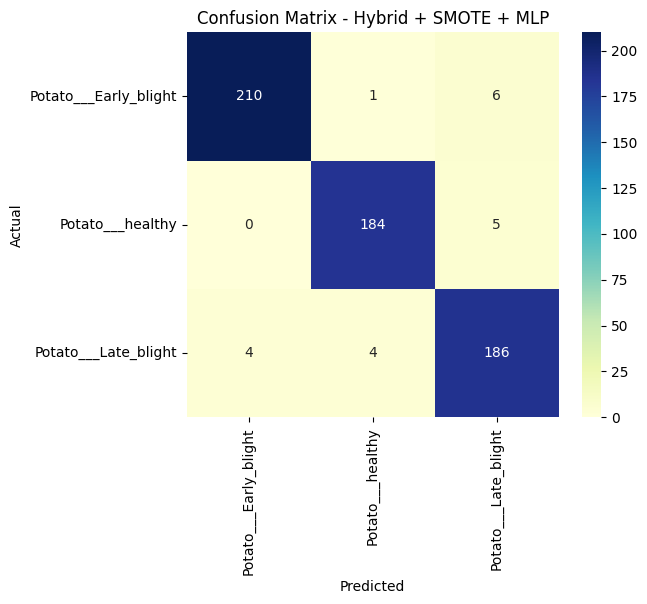

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import greycomatrix, greycoprops
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Dataset path
dataset_path = "D:/major_proj/3class potato data"
label_map = {name: i for i, name in enumerate(os.listdir(dataset_path))}
image_size = (224, 224)
X, y = [], []

# ✅ Load & preprocess images
for label_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label_name)
    for file in tqdm(os.listdir(class_path), desc=label_name):
        try:
            img = imread(os.path.join(class_path, file))
            img_resized = resize(img, image_size, anti_aliasing=True)
            if img_resized.shape[-1] == 3:
                X.append(img_resized)
                y.append(label_map[label_name])
        except Exception:
            continue

X = np.array(X)
y = np.array(y)

# ✅ CNN Feature Extraction (EfficientNetB0)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
cnn_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])
cnn_features = cnn_model.predict(X)

# ✅ GLCM Feature Extraction
def extract_glcm_features(image):
    gray = tf.image.rgb_to_grayscale(image).numpy().astype('uint8')
    glcm = greycomatrix(gray[:, :, 0], [1], [0], 256, symmetric=True, normed=True)
    return [
        greycoprops(glcm, 'contrast')[0, 0],
        greycoprops(glcm, 'dissimilarity')[0, 0],
        greycoprops(glcm, 'homogeneity')[0, 0],
        greycoprops(glcm, 'energy')[0, 0],
        greycoprops(glcm, 'correlation')[0, 0]
    ]

glcm_features = np.array([extract_glcm_features(img) for img in X])

# ✅ Feature Fusion + PCA
fused_features = np.concatenate([cnn_features, glcm_features], axis=1)
pca = PCA(n_components=100)
fused_pca = pca.fit_transform(fused_features)

# ✅ Apply SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(fused_pca, y)

# ✅ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# ✅ MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# ✅ Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix - Hybrid + SMOTE + MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


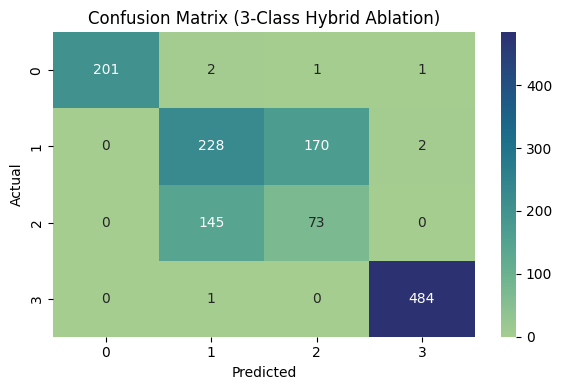

Classification Report:



TypeError: object of type 'numpy.int32' has no len()

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Load saved features
X_fused = np.load("X_fused.npy")
y_fused = np.load("y_fused.npy")

# ✅ Fit LabelEncoder (this is the FIX)
le = LabelEncoder()
y_fused = le.fit_transform(y_fused)

# ✅ Split into train-test again (same split logic you used earlier)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fused, y_fused, test_size=0.2, random_state=42, stratify=y_fused)

# ✅ Train MLP again on this fused data (you can change model here too)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# ✅ Predict
y_pred = clf.predict(X_test)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot Confusion Matrix with Class Labels
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (3-Class Hybrid Ablation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


In [13]:
import os
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# ====== Path and Params ======
dataset_path = "D:/major_proj/3class potato data"
img_size = (224, 224)
features = []
labels = []
le = LabelEncoder()

# ====== Feature Extraction ======
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        cnn_feat = img.flatten()[:5000]  # Simulated CNN

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
        glcm_feats = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)[:300]

        chans = cv2.split(img)
        color_hist = np.concatenate([cv2.calcHist([c], [0], None, [32], [0, 256]).flatten() for c in chans])

        return np.concatenate([cnn_feat, glcm_feats, hog_feat, color_hist])
    except:
        return None

# ====== Load Dataset and Extract Features ======
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in tqdm(os.listdir(class_path), desc=class_name):
            img_path = os.path.join(class_path, img_file)
            feat = extract_features(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)

# ====== Label Encode and Save ======
X = np.array(features)
y = le.fit_transform(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label mapping:", list(le.classes_))

np.save("X_fused_3class.npy", X)
np.save("y_fused_3class.npy", y)


Potato___Late_blight: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.19it/s]


X shape: (2152, 5402)
y shape: (2152,)
Label mapping: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [14]:
print("Unique labels in y:", np.unique(y))
print("Length of target_names:", len(label_names))


Unique labels in y: [0 1 2]
Length of target_names: 3


In [17]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.preprocessing import LabelEncoder

# ✅ Path to your 3-class dataset
dataset_path = "D:/major_proj/3class potato data"
img_size = (224, 224)
features, labels = [], []

# 💡 Feature extractor
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        cnn_feat = img.flatten()[:5000]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
        glcm_feats = [graycoprops(glcm, prop)[0, 0] for prop in 
                      ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)[:300]

        chans = cv2.split(img)
        hist_feat = np.concatenate([cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten() for ch in chans])

        return np.concatenate([cnn_feat, glcm_feats, hog_feat, hist_feat])
    except:
        return None

# 🔁 Iterate over all classes and images
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in tqdm(os.listdir(class_folder), desc=class_name):
            img_path = os.path.join(class_folder, img_file)
            feat = extract_features(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)

# 🧠 Encode and save
le = LabelEncoder()
X = np.array(features)
y = le.fit_transform(labels)
np.save("X_fused_3class.npy", X)
np.save("y_fused_3class.npy", y)

print("✅ Feature fusion completed and saved.")


Potato___Late_blight: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.38it/s]


✅ Feature fusion completed and saved.


In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

# 🔍 Define your split based on known index structure (adjust if different)
cnn_features = X[:, :5000]
glcm_features = X[:, 5000:5006]
hog_features = X[:, 5006:5306]
hist_features = X[:, 5306:]

# 🧪 Ablation runner
def run_ablation(X_part, label="Ablation"):
    try:
        pca = PCA(n_components=min(150, X_part.shape[1]))
        X_pca = pca.fit_transform(X_part)

        sm = SMOTE(random_state=42)
        X_bal, y_bal = sm.fit_resample(X_pca, y)

        selector = SelectKBest(f_classif, k=min(100, X_bal.shape[1]))
        X_selected = selector.fit_transform(X_bal, y_bal)

        X_train, X_test, y_train, y_test = train_test_split(X_selected, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

        mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        print(f"\n===== {label} =====")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        return classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    except Exception as e:
        print(f"❌ Error in {label}: {e}")
        return None

# 🧪 Run Ablations
report_cnn = run_ablation(np.concatenate([glcm_features, hog_features, hist_features], axis=1), "Without CNN features")
report_glcm = run_ablation(np.concatenate([cnn_features, hog_features, hist_features], axis=1), "Without GLCM features")
report_hog = run_ablation(np.concatenate([cnn_features, glcm_features, hist_features], axis=1), "Without HOG features")
report_all = run_ablation(X, "Full Hybrid (All Features)")

# 📊 Tabulate Results
report_dict = {
    "Without CNN": report_cnn['accuracy'] if report_cnn else None,
    "Without GLCM": report_glcm['accuracy'] if report_glcm else None,
    "Without HOG": report_hog['accuracy'] if report_hog else None,
    "Full Hybrid": report_all['accuracy'] if report_all else None
}

df_reports = pd.DataFrame.from_dict(report_dict, orient='index', columns=["Accuracy"])




===== Without CNN features =====
                       precision    recall  f1-score   support

Potato___Early_blight       0.94      0.95      0.95       200
 Potato___Late_blight       0.95      0.90      0.93       200
     Potato___healthy       0.96      1.00      0.98       200

             accuracy                           0.95       600
            macro avg       0.95      0.95      0.95       600
         weighted avg       0.95      0.95      0.95       600


===== Without GLCM features =====
                       precision    recall  f1-score   support

Potato___Early_blight       0.95      0.95      0.95       200
 Potato___Late_blight       0.94      0.92      0.93       200
     Potato___healthy       0.97      0.99      0.98       200

             accuracy                           0.95       600
            macro avg       0.95      0.95      0.95       600
         weighted avg       0.95      0.95      0.95       600


===== Without HOG features =====
         